In [1]:
import torch

import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

class PDEPINN(nn.Module):
  """Physics Informed Neural Network for solving Heat Equation PDE

    Attributes:
        model (nn.Sequential): The neural network model
    """

  def __init__(self, depth, width, activation):
    super(PDEPINN, self).__init__()
    layers = [nn.Linear(2, width), activation()]
    for _ in range(depth - 1):
      layers += [nn.Linear(width, width), activation()]
    layers += [nn.Linear(width, 1), activation()]
    self.model = nn.Sequential(*layers)

  def forward(self, x, t):
      """Forward pass of the network

      Args:
          x (torch.Tensor): Input tensor represention position
          t (torch.Tensor): Input tensor representing time

      Returns:
          torch.Tensor: Output tensor representing the predicted solution u(t)
      """
      inputs = torch.cat((x, t), dim=1)
      return self.model(inputs)

def pde_loss(model, x, t, alpha):
    """Computes the PDE residual for the heat equation

    Args:
        model (HeatEquationPINN): The PINN model
        x (torch.Tensor): Collocation points in the spatial domain
        t (torch.Tensor): Collocation points in the time domain
        alpha (float): Thermal diffusivity constant

    Returns:
        torch.Tensor: Mean squared error of the PDE residual
    """
    x.requires_grad = True
    t.requires_grad = True

    u = model(x, t)

    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]

    residual = u_t - alpha * u_xx
    return torch.mean(residual ** 2)

def boundary_loss(model, x_boundary, t_boundary):
    """Computes the boundary condition loss.

    Args:
        model (HeatEquationPINN): The PINN model.
        x_boundary (torch.Tensor): Position points for boundary conditions
        t_boundary (torch.Tensor): Time points for the boundary conditions

    Returns:
        torch.Tensor: Mean squared error of the boundary condition residuals
    """
    u_boundary = model(x_boundary, t_boundary)
    return torch.mean(u_boundary ** 2)  # u = 0 at boundaries


def initial_condition_loss(model, x_initial, t_initial, u_initial):
    """Computes the initial condition loss.

    Args:
        model (HeatEquationPINN): The PINN model
        x_initial (torch.Tensor): Position points for the initial condition
        t_initial (torch.Tensor): Time points for the initial condition (t=0)
        u_initial (torch.Tensor): Exact initial condition values (u(x, 0))

    Returns:
        torch.Tensor: Mean squared error of the initial condition residuals.
    """
    u_pred = model(x_initial, t_initial)
    return torch.mean((u_pred - u_initial) ** 2)  # u(x, 0) = sin(pi * x)


def train_pde_pinn(model, diffusivity, epochs, optimizer_class=optim.SGD, optimizer_params=None):
    """Trains the PINN model to solve the 1D heat equation

    Args:
        model (PDEPINN): The PINN model
        alpha (float): Thermal diffusivity constant
        epochs (int): Number of training epochs
        learning_rate (5float): Learning rate for the optimizer

    Returns:
        PDEPINN: The trained PINN model
    """
    # This can be more customizable in the future
    if optimizer_params is None:
        optimizer_params = {"lr": 1e-3}

    optimizer = optimizer_class(model.parameters(), **optimizer_params)

    x_collocation = torch.rand(1000, 1)  # Random points in [0, 1]
    t_collocation = torch.rand(1000, 1)  # Random points in [0, T]

    x_boundary = torch.cat((torch.zeros(100, 1), torch.ones(100, 1)), dim=0)  # x = 0 and x = 1
    t_boundary = torch.rand(200, 1)  # Random t for boundary conditions

    x_initial = torch.linspace(0, 1, 100).unsqueeze(1)  # x in [0, 1]
    t_initial = torch.zeros(100, 1)  # t = 0
    u_initial = torch.sin(np.pi * x_initial)  # u(x, 0) = sin(pi * x)

    for epoch in range(epochs):
        optimizer.zero_grad()

        pde_pinn_loss = pde_loss(model, x_collocation, t_collocation, diffusivity)
        b_loss = boundary_loss(model, x_boundary, t_boundary)
        ic_loss = initial_condition_loss(model, x_initial, t_initial, u_initial)

        loss = pde_pinn_loss + b_loss + ic_loss
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")

    return model


Epoch 0, Loss: 0.4405163526535034
Epoch 25, Loss: 0.27425986528396606
Epoch 50, Loss: 0.2686801552772522
Epoch 75, Loss: 0.25883203744888306
Epoch 100, Loss: 0.22687366604804993
Epoch 125, Loss: 0.12865473330020905
Epoch 150, Loss: 0.01886119320988655
Epoch 175, Loss: 0.0075589921325445175
Epoch 200, Loss: 0.0042283860966563225
Epoch 225, Loss: 0.0035851765424013138
Epoch 250, Loss: 0.0031650091987103224
Epoch 275, Loss: 0.0028273670468479395


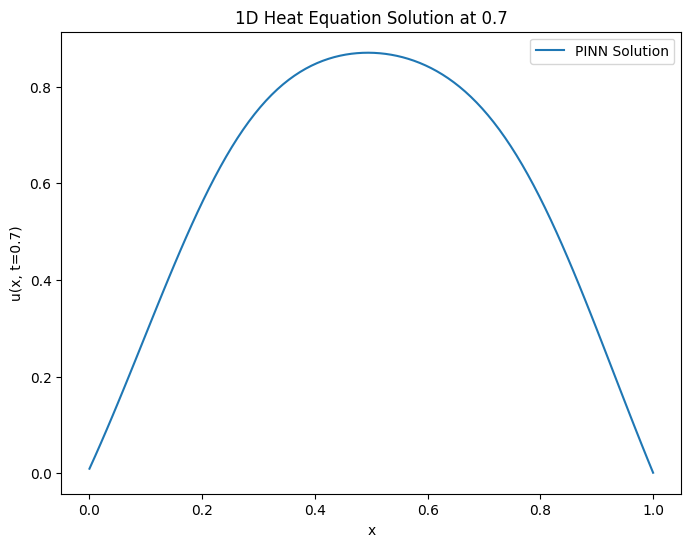

In [4]:
diffusivity = 0.01
time = 0.5

model = PDEPINN(depth=3, width=50, activation=nn.Tanh)

trained_model = train_pde_pinn(model, diffusivity, epochs=300, optimizer_class=optim.Adam)

x_test = torch.linspace(0, 1, 100).unsqueeze(1)
t_test = torch.full_like(x_test, time)
u_predict = trained_model(x_test, t_test).detach().numpy()

plt.figure(figsize=(8, 6))
plt.plot(x_test.numpy(), u_predict, label="PINN Solution")
plt.xlabel("x")
plt.ylabel(f'u(x, t={time})')
plt.title(f'1D Heat Equation Solution at {time}')
plt.legend()
plt.show()

# Github
## https://github.com/RustyRodriguez/physics-informed-neural-networks